# Data insights
We are analysing the Level 5 data from the LINCS Github:
https://github.com/broadinstitute/lincs-cell-painting/tree/master/consensus/2016_04_01_a549_48hr_batch1

This notebook will simply give some insight into the data for later analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cytominer_eval import evaluate
from pycytominer.cyto_utils import infer_cp_features
from cytominer_eval.transform import metric_melt

In [19]:
data_dir = '../01_data/2016_04_01_a549_48hr_batch1_consensus_modz_feature_select_dmso.csv.gz'
df = pd.read_csv(data_dir)
print('Shape: ', df.shape)
df.head(5)

Shape:  (10752, 528)


,Metadata_Plate_Map_Name,Metadata_cell_id,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,Metadata_time_point,Metadata_moa,Metadata_target,Cells_AreaShape_Area,...,Nuclei_Texture_InverseDifferenceMoment_RNA_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_20_0,Nuclei_Texture_SumAverage_DNA_20_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_20_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,C-7161-01-LM6-001,A549,BRD-A25234499-001-18-3,B13,10.00000,6,48H,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,0.344670,...,-0.302193,-0.262680,-0.643318,-0.307924,-0.263607,-0.771062,-0.622449,-0.968180,0.087257,0.691044
1,C-7161-01-LM6-001,A549,BRD-A25234499-001-18-3,B14,3.33330,5,48H,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,0.488995,...,-0.498673,0.301335,-0.161695,-2.046360,-0.147213,-0.230816,-0.157423,-0.247806,0.243377,-1.196500
2,C-7161-01-LM6-001,A549,BRD-A25234499-001-18-3,B15,1.11110,4,48H,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,0.505526,...,-0.250714,-0.020691,0.722674,-0.759924,-0.012077,-0.270183,-0.134932,-0.359148,0.276299,-0.796096
3,C-7161-01-LM6-001,A549,BRD-A25234499-001-18-3,B16,0.37037,3,48H,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,0.092069,...,-0.338021,0.568476,-0.552219,-0.770124,-0.391011,-0.667111,-0.517957,-0.674251,0.022910,-0.944185
4,C-7161-01-LM6-001,A549,BRD-A25234499-001-18-3,B17,0.12346,2,48H,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,0.705527,...,-0.277073,0.775823,-0.895731,-0.762473,-0.429907,-0.214208,-0.198268,-0.241933,0.026242,-0.849128


In [20]:
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)
print('Metadata features:\n',meta_features)
print('Nr of features: ', len(features))

Metadata features:
 ['Metadata_Plate_Map_Name', 'Metadata_cell_id', 'Metadata_broad_sample', 'Metadata_pert_well', 'Metadata_mmoles_per_liter', 'Metadata_dose_recode', 'Metadata_time_point', 'Metadata_moa', 'Metadata_target']
Nr of features:  519


### Pertubations
The original data was made from 136 plate with 384 wells each.
However, since this is aggregated data, the plate names are not relevant anymore.

As can be seen below, the DMSO and positive controls are still in the data. These three compounds may not be added to the  final analysis since they are meant for normalization.

Negative control: DMSO
Positive control 1: BRD-K60230970-001-10-0
Positive control 2: BRD-K50691590-001-02-2

In [43]:
print('Nr of different pertubations: ', len(df.Metadata_broad_sample.unique()))
df.Metadata_broad_sample.value_counts()

Nr of different pertubations:  1571


DMSO                      672
BRD-K60230970-001-10-0    336
BRD-K50691590-001-02-2    336
BRD-K72029282-001-22-0      6
BRD-A92826379-001-01-5      6
                         ... 
BRD-K09090949-001-01-9      6
BRD-K77396579-300-01-0      6
BRD-K62398570-300-01-2      6
BRD-K73395020-001-02-3      6
BRD-K95763993-001-19-3      6
Name: Metadata_broad_sample, Length: 1571, dtype: int64

### Methods of action
The three controls make up the largest MOAs. (unknown, proteasome inhibitor and NFkB pathway inhibitor)
Following, are a number of MOA's that have many compounds, while other MOAs only 'have' one compounds.

Some compounds have no MOA assigned and this allows us to drop then because they won't be helpful during the analysis.

In [44]:
print('Nr of different moa: ', len(df.Metadata_moa.unique()))
df.Metadata_moa.value_counts()

Nr of different moa:  602


unknown                                               984
proteasome inhibitor                                  366
NFkB pathway inhibitor|proteasome inhibitor           342
phosphodiesterase inhibitor                           210
adrenergic receptor antagonist                        198
                                                     ... 
catechol O methyltransferase inhibitor                  6
exportin antagonist                                     6
phosphodiesterase inhibitor|sodium channel blocker      6
mucus protecting agent                                  6
NADPH inhibitor                                         6
Name: Metadata_moa, Length: 602, dtype: int64

In [13]:
# We can also create a dict of all moas and how many compounds belong to that MOA.
moa_dict = {}
for moa in df.Metadata_moa.unique():
    moa_dict[moa] = len(df.query("Metadata_moa == @moa").Metadata_broad_sample.unique())

In [16]:
for n in range(20):
    print(f'{n}: {list(moa_dict.values()).count(n)}')

0: 0
1: 366
2: 84
3: 41
4: 24
5: 26
6: 18
7: 13
8: 5
9: 2
10: 4
11: 2
12: 2
13: 0
14: 3
15: 1
16: 1
17: 2
18: 0
19: 0


The largest number of MOAs only have on compound. But we can't use these since they will not allow for any replicate evaluation.

In [22]:
df = pd.concat(
 [df.query("Metadata_moa != 'unknown'"),
 df.query("Metadata_broad_sample == 'DMSO'")],
    ignore_index=True
)

### Concentrations

Most compounds have 6 different concentrations, which are defined by the dose record, not by the mmoles per liter.

Furthermore, the positive controls have the value code 7 for their concentration.
If we thus only query for the concentrations 6 and 0, then we will get the negative controls and one of each pertubation.

In [23]:
print('Nr of different mmoles: ', len(df.Metadata_mmoles_per_liter.unique()))
print('Nr of different dose codes: ', len(df.Metadata_dose_recode.unique()))
print(df.Metadata_dose_recode.value_counts())
print(df.query("Metadata_dose_recode == 7").Metadata_broad_sample.value_counts())

Nr of different mmoles:  87
Nr of different dose codes:  8
1    1530
2    1516
3    1516
4    1516
5    1511
6    1507
0     672
7     672
Name: Metadata_dose_recode, dtype: int64
BRD-K50691590-001-02-2    336
BRD-K60230970-001-10-0    336
Name: Metadata_broad_sample, dtype: int64


In [25]:
df = df.query("Metadata_dose_recode == 0 | Metadata_dose_recode == 6 ")

## Feature selection

When running any kind of replicate similarity evaluation (which is what we are using as a metric) then you will notice some strange behaviour of very high correlations.

Here, we show how the similarities are very high due to some very high values accross the feature space.

In [22]:
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)
similarity_metric="pearson"
operation="precision_recall"

similarity_melted_df = metric_melt(
            df=df,
            features=features,
            metadata_features=meta_features,
            similarity_metric=similarity_metric,
            eval_metric=operation,
        )
plt.hist(similarity_melted_df.similarity_metric)
plt.show()

The plot above shows how a very large number of points have similarity 1 or -1. This is due to some features having very large values which dominiate the similarity.

Here are two examples: BRD-A26334849-001-06-2, BRD-A25234499-001-18-3

The plot below shows how for two randomly selected samples, there is one feature which has a very large value for both samples.
These high values stem from the analysis leading up to here where Sphering can create high values.
Thus, we want to further drop the features that have these high values.

The notebook clean_data shows how I drop the features with high values.

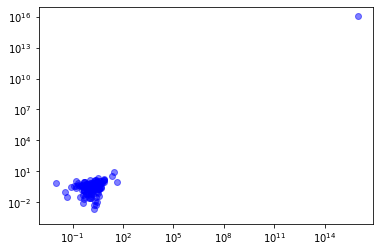

In [35]:
s1 = "BRD-A26334849-001-06-2"
s2 = "BRD-A25234499-001-18-3"
test_df = pd.concat([
df.query("Metadata_broad_sample==@s1  & Metadata_dose_recode == 6"),
df.query("Metadata_broad_sample==@s2  & Metadata_dose_recode == 6")
    ], ignore_index=True)
test_df = test_df.loc[:, features].T
test_df.columns = ['One','Two']

ax = plt.gca()
ax.plot(test_df['One'] ,test_df['Two'], 'o', c='blue', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Other data

This files holds the mapping between targets, broad samples IDs, compounds and MOA.
https://github.com/broadinstitute/lincs-cell-painting/blob/master/metadata/moa/repurposing_info_external_moa_map_resolved.tsv

In [26]:
df.Metadata_broad_sample.value_counts()


DMSO                      672
BRD-K19111024-001-20-9      1
BRD-K83794243-001-01-8      1
BRD-K03384561-001-02-7      1
BRD-A62071884-001-04-6      1
                         ... 
BRD-K71822263-001-03-2      1
BRD-K63430059-001-17-2      1
BRD-K18673820-001-15-5      1
BRD-K02292852-001-02-1      1
BRD-A52922642-001-03-7      1
Name: Metadata_broad_sample, Length: 1508, dtype: int64

In [27]:
dic = {}
for moa in df.Metadata_moa.unique():
    dic[moa] = len(df.query("Metadata_moa == @moa").Metadata_broad_sample.unique())

In [5]:
dic


{'glucocorticoid receptor antagonist': 1,
 'calmodulin antagonist': 2,
 'glucocorticoid receptor agonist': 17,
 'antiarrhythmic': 1,
 'HIV protease inhibitor': 7,
 'calcium channel blocker': 16,
 'FLT3 inhibitor|growth factor receptor inhibitor|JAK inhibitor': 1,
 'voltage-gated sodium channel blocker': 3,
 'mTOR inhibitor|PI3K inhibitor': 6,
 'monoamine oxidase inhibitor': 6,
 'neurotrophic agent': 3,
 'adrenergic receptor antagonist': 33,
 'platelet activating factor receptor antagonist': 3,
 'mineralocorticoid receptor antagonist': 3,
 'lipid peroxidase inhibitor': 2,
 'progesterone receptor agonist': 7,
 'sodium channel blocker': 14,
 'bacterial 30S ribosomal subunit inhibitor': 4,
 'unknown': 53,
 'nitric oxide synthase inhibitor': 5,
 'glutamate receptor modulator': 4,
 'helicase primase inhibitor': 1,
 'matrix metalloprotease inhibitor': 3,
 'cyclooxygenase inhibitor': 29,
 'acetylcholinesterase inhibitor|cholinesterase inhibitor': 1,
 'dopamine receptor antagonist|serotonin rec

In [11]:
for n in range(20):
    print(f'{n}: {list(dic.values()).count(n)}')

0: 0
1: 366
2: 84
3: 41
4: 24
5: 26
6: 18
7: 13
8: 5
9: 2
10: 4
11: 2
12: 2
13: 0
14: 3
15: 1
16: 1
17: 2
18: 0
19: 0
